First we will start by bringing some code we need to start with this like our custom class, custom dataset and functions for training and testing

In [30]:
import torch
from torch import nn
import torchvision
import pathlib
import matplotlib.pyplot as plt

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [32]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [33]:
train_dir= image_path / "train"
test_dir=  image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [34]:
from torchvision import transforms
from typing import Tuple, Dict, List
def find_classes(directory:str)-> Tuple[List[str], Dict[str, int]]:
    classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    classes_to_idx= {cls_name:i for i, cls_name in enumerate(classes)}
    return classes, classes_to_idx

In [35]:
#now we are going to create the custom Dataset class
from torch.utils.data import Dataset
from pathlib import Path

class ImageFolderCustom(Dataset): # we need to subclass Dataset
    def __init__(self, target_dir:str, transform:None) ->None:
        self.paths= list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform= transform
        self.classes, self.classes_to_idx = self.find_classes(target_dir)
    
    def find_classes(self,directory:str)-> Tuple[List[str], Dict[str, int]]:
        self.classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not self.classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}")
        self.classes_to_idx= {cls_name:i for i, cls_name in enumerate(self.classes)}
        return self.classes, self.classes_to_idx
    
    def load_image(self, index:int):
        image_path= self.paths[index]
        return Image.open(image_path)
    
    # here we will overide the method that returns length
    def __len__(self)->int:
        return len(self.paths)
    
    # overide(necessary) getitem method which returns one sample of data (image and label)
    def __getitem__(self, index):
        img= self.load_image(index)
        class_name= self.paths[index].parent.name
        class_idx= self.classes_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [36]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [37]:
def train_run(
    model:nn.Module,
    train_data:torch.utils.data.DataLoader,
    lossFn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device:torch.device    
):
    loss_total=0
    model.to(device)
    model.train()
    true_predictions=0
    total_image_count= 0
    for i, (a_batch_images, labels) in enumerate(train_data):
            a_batch_images=a_batch_images.to(device)
            labels= labels.to(device)
            y_logits= model(a_batch_images)
            y_preds= torch.argmax(y_logits, dim=1)
            loss= lossFn(y_logits, labels)
            loss_total += loss.item()
            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
    loss= loss_total / len(train_data)
    accuracy = true_predictions /  total_image_count
    return {
        'loss': loss,
        'accuracy': accuracy
    }

def test_run(
    model: nn.Module,
    test_data: torch.utils.data.DataLoader,
    lossFn: nn.Module,
    device: torch.device
):
    loss_total = 0
    true_predictions = 0
    total_image_count = 0

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (a_batch_images, labels) in enumerate(test_data):
            a_batch_images = a_batch_images.to(device)
            labels = labels.to(device)

            y_logits = model(a_batch_images)
            y_preds = torch.argmax(y_logits, dim=1)

            loss = lossFn(y_logits, labels)
            loss_total += loss.item()

            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)

    loss = loss_total / len(test_data)
    accuracy = true_predictions / total_image_count

    return {
        "loss": loss,
        "accuracy": accuracy
    }
    

from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    epochs: int = 5
):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):

        train_metrics = train_run(
            model=model,
            train_data=train_dataloader,
            lossFn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_metrics = test_run(
            model=model,
            test_data=test_dataloader,
            lossFn=loss_fn,
            device=device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_metrics['loss']:.4f} | "
            f"train_acc: {train_metrics['accuracy']:.4f} | "
            f"test_loss: {test_metrics['loss']:.4f} | "
            f"test_acc: {test_metrics['accuracy']:.4f}"
        )

        results["train_loss"].append(train_metrics["loss"])
        results["train_acc"].append(train_metrics["accuracy"])
        results["test_loss"].append(test_metrics["loss"])
        results["test_acc"].append(test_metrics["accuracy"])

    return results

In [38]:
def find_classes(directory:str)-> Tuple[List[str], Dict[str, int]]:
    classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    classes_to_idx= {cls_name:i for i, cls_name in enumerate(classes)}
    return classes, classes_to_idx

In [42]:
from torchvision import transforms
from torch.utils.data import DataLoader

train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_simple= ImageFolderCustom(train_dir, train_transform_trivial_augment)
test_data_simple= ImageFolderCustom(test_dir, test_transform)
train_dataloader_simple= DataLoader(
    dataset= train_data_simple,
    batch_size=1, 
    num_workers=1,
    shuffle=True,
)
test_dataloader_simple= DataLoader(
    dataset= test_data_simple,
    batch_size=1,
    num_workers=0,
    shuffle=False
)



In [44]:
from timeit import default_timer as timer
from PIL import Image
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_simple.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device= device,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1084 | train_acc: 0.2933 | test_loss: 1.1008 | test_acc: 0.3067
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.2756 | test_loss: 1.0999 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3156 | test_loss: 1.1000 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.1019 | train_acc: 0.3733 | test_loss: 1.1307 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.1053 | train_acc: 0.3289 | test_loss: 1.1024 | test_acc: 0.3333
Total training time: 8.376 seconds


In [45]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


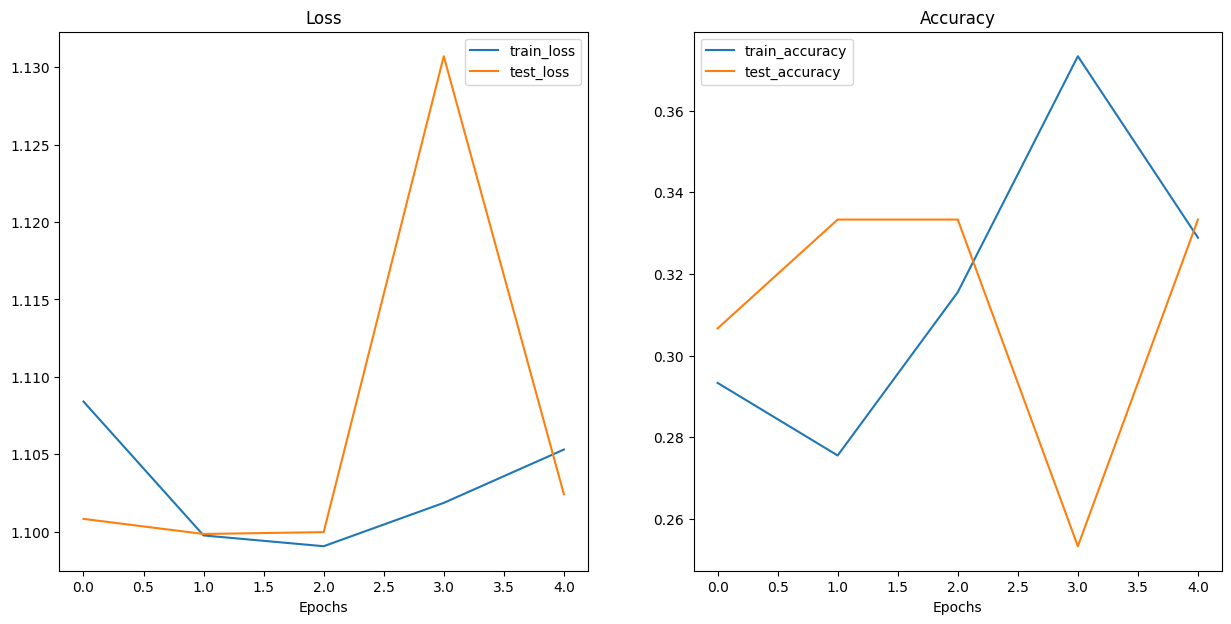

In [46]:
print(model_0_results.keys())
plot_loss_curves(model_0_results)

# We have completed importing all neccessary code from part one